In [2]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [3]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02514/

In [4]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/dtu/datasets1/02514/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [5]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

Let's look at some images from our data 

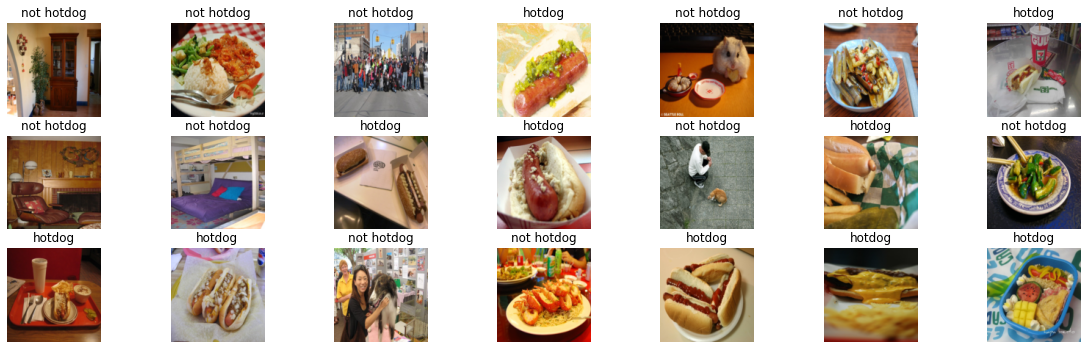

In [6]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Remember to save the state of your model AND optimizer regularly in case the Colab runtime times out.
You can save your model to your google drive, so you can get it from there in a new colab session. 

If you only save it in the colab notebook, there's no way to get it into a new session.

Now create a model and train it!


In [7]:
images[0].shape

torch.Size([3, 128, 128])

In [8]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
                nn.Conv2d(in_channels=3,
                        out_channels=8,
                        kernel_size=(3,3),
                        padding='same'),
                nn.ReLU(),
                nn.Conv2d(in_channels=8,
                          out_channels=8,
                          kernel_size=(3,3),
                         padding='same'),
                nn.ReLU(),
                nn.Conv2d(in_channels=8,
                          out_channels=16,
                          kernel_size=(3,3),
                         padding='same'),
        )

        self.fully_connected = nn.Sequential(
                nn.Linear(128*128*16, 500),
                nn.ReLU(),
                nn.Linear(500, 2),
#                 nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x
       
    

In [9]:
model = Network()
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

#Get the first minibatch
data = next(iter(train_loader))[0].to(device)
#Try running the model on a minibatch
print('Shape of the output from the convolutional part', model.convolutional(data).shape)
predict = model(data)
# print(predict); #if this runs the model dimensions fit
# print(torch.max(predict,1))

Shape of the output from the convolutional part torch.Size([64, 16, 128, 128])


In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [12]:
num_epochs = 5

for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_correct = 0
    model.train()
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer.zero_grad()
        #Forward pass your image through the network
        output = model(data)
        #Compute the loss
        loss = criterion(output, target)
        #Backward pass through the network
        loss.backward()
        #Update the weights
        optimizer.step()
        
        #Compute how many were correctly classified
        predicted = output.argmax(1)
        train_correct += (target==predicted).sum().cpu().item()
    #Comput the test accuracy
    test_correct = 0
    model.eval()
    for data, target in test_loader:
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
        predicted = output.argmax(1).cpu()

        test_correct += (target==predicted).sum().item()
        loss_test = criterion(predicted, target)
    train_acc = train_correct/len(trainset)
    test_acc = test_correct/len(testset)
    print("Accuracy train: {train:.1f}%\t test: {test:.1f}% \t Loss: {loss:.3f}".format(test=100*test_acc, train=100*train_acc, loss=loss))

  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

RuntimeError: Expected floating point type for target with class probabilities, got Long

In [14]:
loss = criterion(output, target)
print(loss)

tensor(0.4285, device='cuda:0', grad_fn=<NllLossBackward0>)
